# A Complete Machine Learning Project

Think of it as a demonstration of a complete project, with hyperparameter optimization!


##Start with imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Have a goal for the analysis. This is quite understated yet extremely important on how you're model will be used for. How accurate does your prediction need to be? How fast does your model need to run and how often? I can keep going but I'll just provide an example:


As your "boss" I would like you to predict the median housing price for the state of california based on the census data provided. I don't care about WHY certain districts are more expensive, I want to look at new districts and have a good approximation of housing prices there.

`pd.read_csv()` This allows us to read any csv file (`pd_read_excel()`) is also an option. All the data being used is in the ***Files*** tab on the left. You can upload your own files using the arrow symbol. 


In [ ]:
dfin = pd.read_csv('/content/sample_data/california_housing_train.csv')
df_finaltest = pd.read_csv('/content/sample_data/california_housing_test.csv')

If you were wondering where the files came from, click the file folder symbol on the left of Google Colab. This dataset is from the sample data provided by colab. 
> *Folder symbol* -> sample_data -> *RIGHT CLICK* california_housing_train.csv -> Copy path

### Why do we have 2 files?

We've talked a lot about validation already, but in the real world we only get to make predicitions ***ONCE***. So we with-hold a certain amount of data, calling it the  FINAL (witheld) TEST SET. AT the end we take our trained model and make predictions on this witheld (test) data **ONCE** to get our final accuracy score.

This is similar to putting the two methods we have together. Training data will be adjusted using cross validation, and testing data will be used to make predictions at the very end, reread: once. we will do all our work (train, validate , optimize) with `dfin` (including cross validation) and NOT touch `df_finaltest` until the very end. This is what the data loos like:

![alt text](https://i.imgur.com/qdqE0O2.png)



## Continued (Transformation and visualization) from before

In [ ]:
dfin.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


Our first step doesn't change:

In [ ]:
dfin.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

Luckily, most of the data is already numerical:

In [ ]:
dfin.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
df_finaltest.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

Luckily no null values in either file! There are 17000 datapoints, lets only plot a sample:

In [ ]:
df_plotsample = dfin.sample(500)

A new function here: creates a histogram plot!

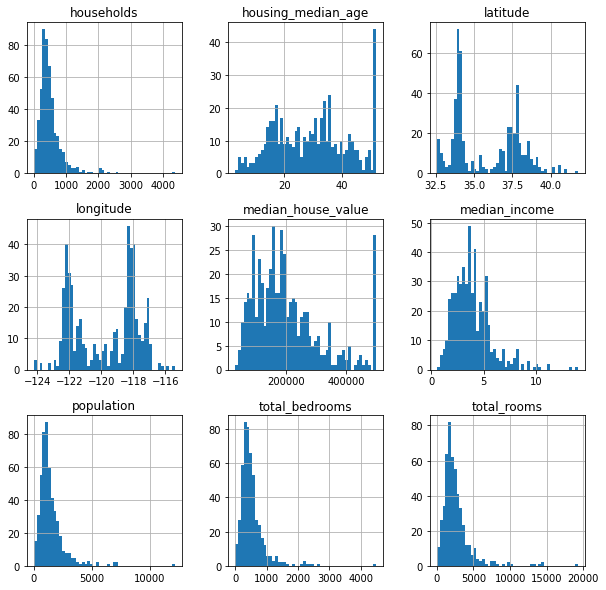

In [ ]:
df_plotsample.hist(bins = 50, figsize = (10,10))
plt.show()

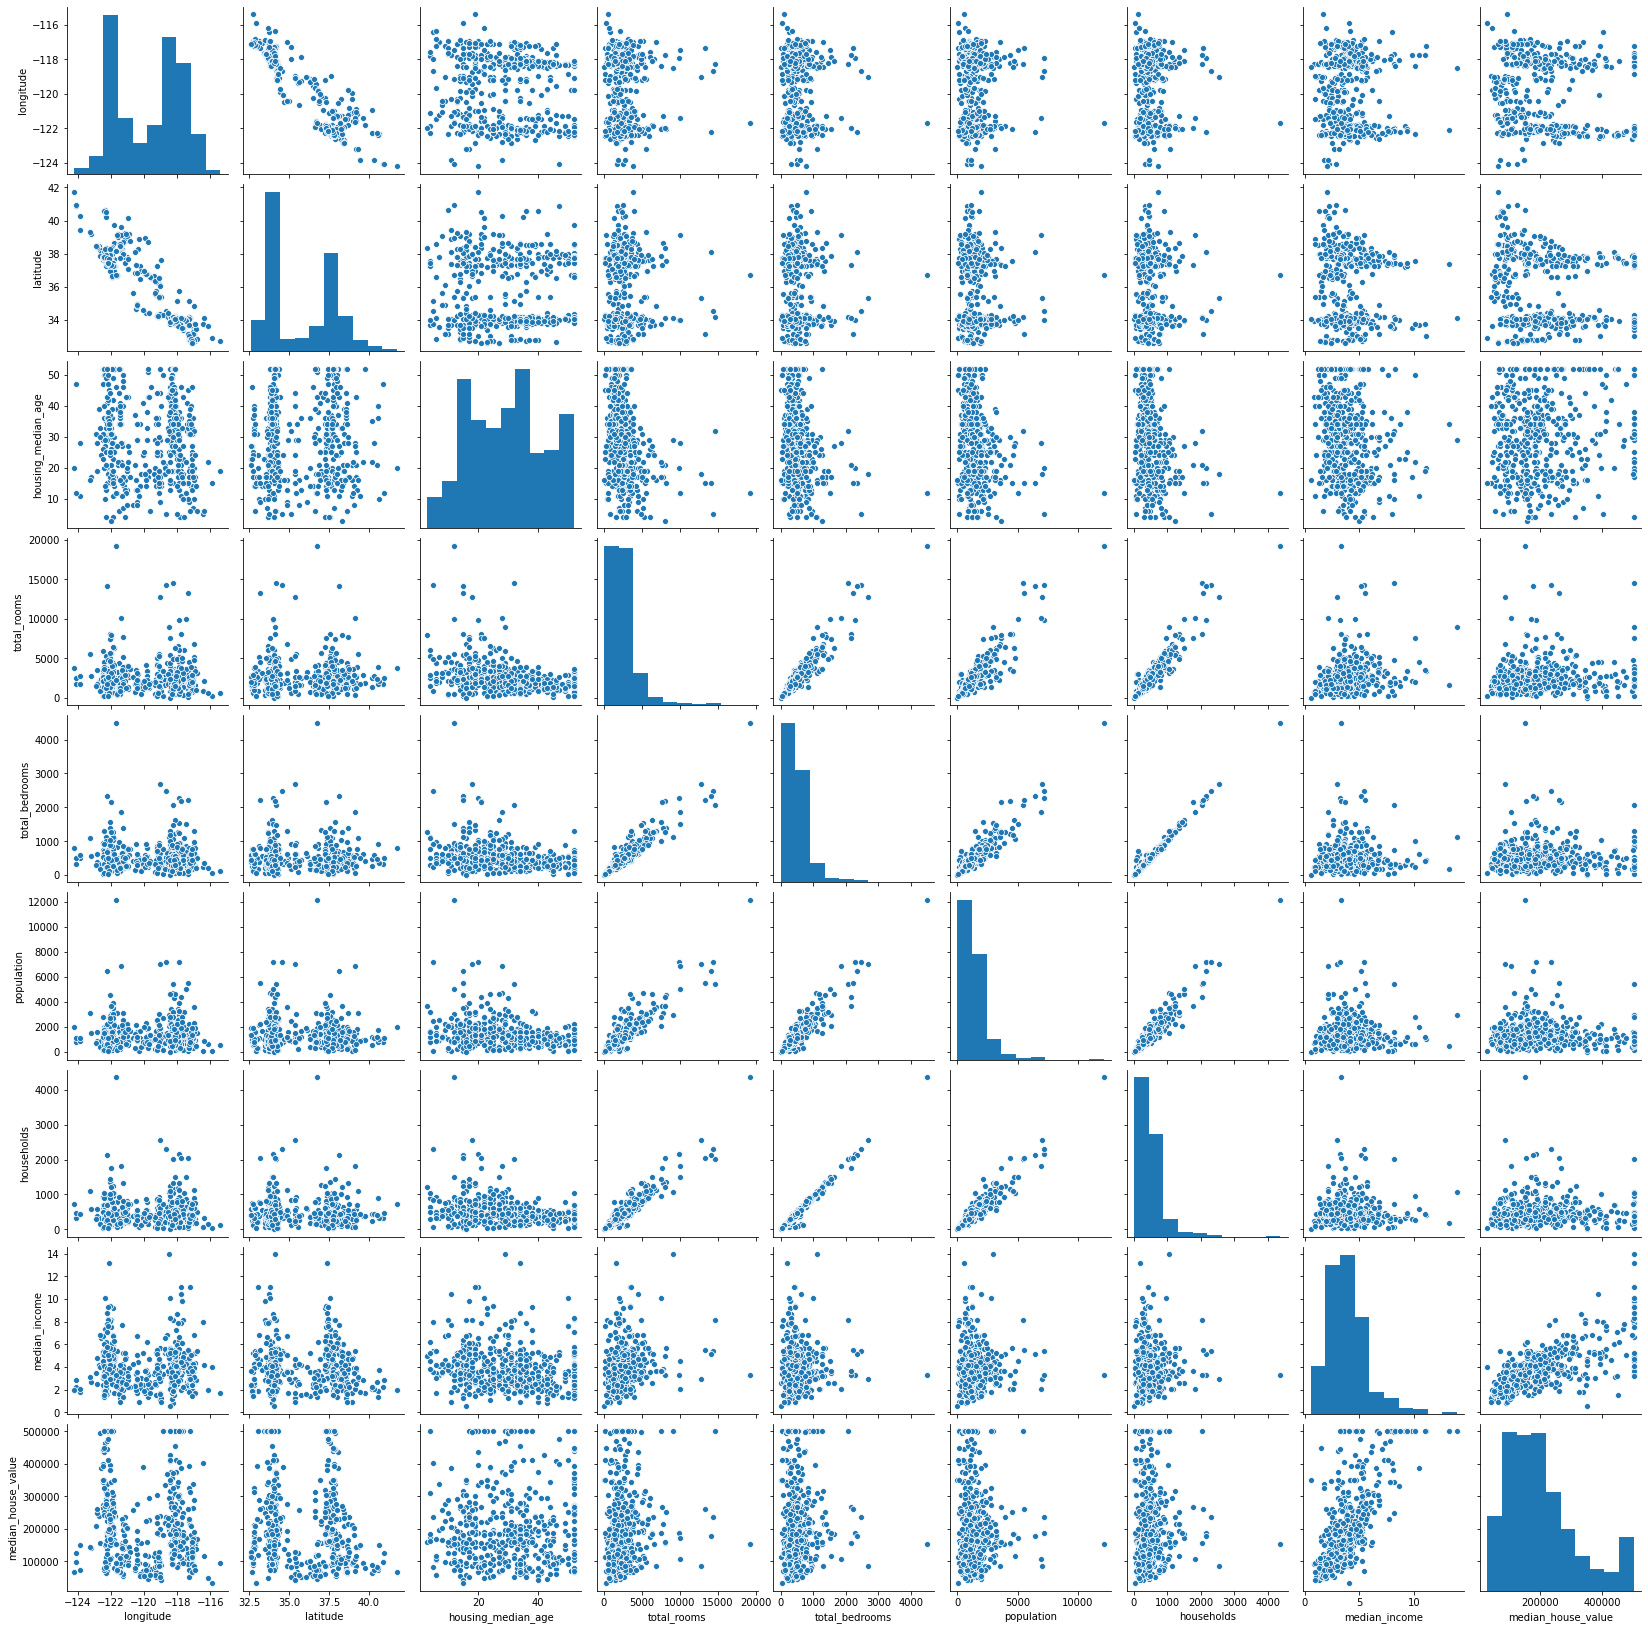

In [ ]:
sns.pairplot(df_plotsample)

An alternative to pairplot is to look at the CORRELATION to the column of interest (`median_house_value`)

In [ ]:
dfin.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925208,-0.114250,0.047010,0.071802,0.101674,0.059628,-0.015485,-0.044982
latitude,-0.925208,1.000000,0.016454,-0.038773,-0.069373,-0.111261,-0.074902,-0.080303,-0.144917
housing_median_age,-0.114250,0.016454,1.000000,-0.360984,-0.320434,-0.295890,-0.302754,-0.115932,0.106758
total_rooms,0.047010,-0.038773,-0.360984,1.000000,0.928403,0.860170,0.919018,0.195383,0.130991
total_bedrooms,0.071802,-0.069373,-0.320434,0.928403,1.000000,0.881169,0.980920,-0.013495,0.045783
population,0.101674,-0.111261,-0.295890,0.860170,0.881169,1.000000,0.909247,-0.000638,-0.027850
households,0.059628,-0.074902,-0.302754,0.919018,0.980920,0.909247,1.000000,0.007644,0.061031
median_income,-0.015485,-0.080303,-0.115932,0.195383,-0.013495,-0.000638,0.007644,1.000000,0.691871
median_house_value,-0.044982,-0.144917,0.106758,0.130991,0.045783,-0.027850,0.061031,0.691871,1.000000


It appears the most important factor of predicting median house value is the `median_income` by a longshot, and then `total_rooms`, `housing_median_age`

## NEXT We have options here: 
Generate features now, or build a model first. 

In [ ]:
inputs_basic = dfin.drop(columns = 'median_house_value')

If you want to be quick and "lazy" then taking the inputs as they are (after clearing no nulls) you can go straight into modelling. There's a chance that the model will give you the accuracy you need without extra work.

But to be proper with our data science work, we generally make new features. To do so, we make a copy first so `dfin` is unaffected by our work. 

In [ ]:
df_newfeats = dfin.copy()

A few new features/columns using our limited real estate knowledge would be: 

In [ ]:
df_newfeats['bedrooms_per_room'] = df_newfeats['total_bedrooms'] / df_newfeats['total_rooms']
df_newfeats['population_per_household'] = df_newfeats['population'] / df_newfeats['households']

We also want to investigate the geography of California

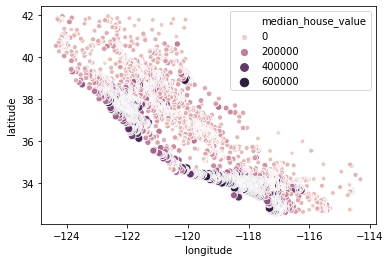

In [ ]:
sns.scatterplot('longitude','latitude', size = 'median_house_value', hue = 'median_house_value', data = dfin)

Ideally we can find a variable that measures distance to the coast line, however an approximation can be made by using an equation of a line y = mx+ b. Basically add 130 to longitude so its approximately the same as latitude, and then divide the two. 

In [ ]:
df_newfeats['long_over_lat'] = (df_newfeats['longitude'] + 130) / (df_newfeats['latitude'])

In [ ]:
df_newfeats.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,bedrooms_per_room,population_per_household,long_over_lat
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0,0.228617,2.150424,0.458906
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0,0.248497,2.438445,0.451453
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0,0.241667,2.846154,0.458296
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0,0.224517,2.278761,0.458680
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0,0.224209,2.381679,0.459637


Remember to drop the column we are actually predicting, after saving it as ypred. 

In [ ]:
ypred = df_newfeats['median_house_value']
inputs_new = df_newfeats.drop(columns = 'median_house_value')

Time for our baseline model, a linear regression!! And we'll import cross val score knowing we will need it. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

We will choose mean squared error, this choice is arbitrary
---
but we want to heavily penalize predictions that are a long ways off, so squaring the error makes sense compared to taking absolute error, note that we take the square root of the mean square error, so if our root mean sq error is 70 000, we can still say our predictions were about $70 000 off (from the real price) on average. 



In [ ]:
lin_model = LinearRegression()
lin_scores = cross_val_score(lin_model, inputs_new, ypred, scoring = 'neg_root_mean_squared_error')
lin_scores

array([-73956.50727693, -59877.20666773, -86546.85910712, -80740.94933643,
       -74396.15270419])

If cross_val_score confuses you, refer to Module 3! (specifically Section 3.5) Recall that we didn't actually fit to lin_model, so we can't use `lin_model`.`predict(...` In the background, cross_val_score actually does use the fit method to calculate the error on each validation fold, but we don't see that effect. 


## A new model appears!!
As we now know, there are other models available to us. 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth = 10)
tree_scores = cross_val_score(tree_reg, inputs_new, ypred, scoring = 'neg_root_mean_squared_error')
tree_scores

array([-122719.13589746,  -66359.18799233,  -90068.11731431,
        -66436.31320415, -112178.41971995])

A decision tree is beneficial in that it's quick to train and predict, and that trees can be very different from each other and still get similar predictions. However a decision tree is very very susceptible to overfitting. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, min_samples_split = 2)
forest_scores = cross_val_score(forest_reg, inputs_new, ypred, scoring = 'neg_root_mean_squared_error')
forest_scores

array([-104701.82418695,  -51902.3000618 ,  -75544.02132472,
        -58618.71208906,  -86802.42102817])

The downside to this more complex (upside = more powerful) model is that there are more parameters, many more hyperparameters than the `alpha` we optimized for yesterday. By hovering over the `RandomForestRegressor()` initial declaration, we can see all the parameters we can specify. In the example above, we specified none of them and used the default, there is room for improvement if we find the new hyperparameters. 


## How do we find the best model?

*But with more hyperparamters, there are more combinations to search.* If there were two hyperparmeters: `number of estimators` (can take any number from 0 to ~1000) and `min_sample_split` (can take any number from 1 to ~10 000) of of the forest model, then there are a ton of combinations to search for. 

One option would be divide up the two parameters into intervals, and search regualar intervals so `number of estimators` could be [10,50,100,500] and `min_sample_split` could be [1, 2, 10, 50, 100, 1000] and we try **EVERY POSSIBLE COMBINATION**



```
forest_reg1 = RandomForestRegressor(n_estimators=10, min_samples_split = 1)
score1 = cross_val_score(forest_reg, inputs_new, ypred, scoring = 'neg_root_mean_squared_error')
forest_reg2 = RandomForestRegressor(n_estimators=10, min_samples_split = 2)
score2 = cross_val_score(forest_reg, inputs_new, ypred, scoring = 'neg_root_mean_squared_error')
forest_reg3 = RandomForestRegressor(n_estimators=10, min_samples_split = 10)
score3 =...

```

This method of searching is called GRID SEARCH and can be seen in the left of the image below. 



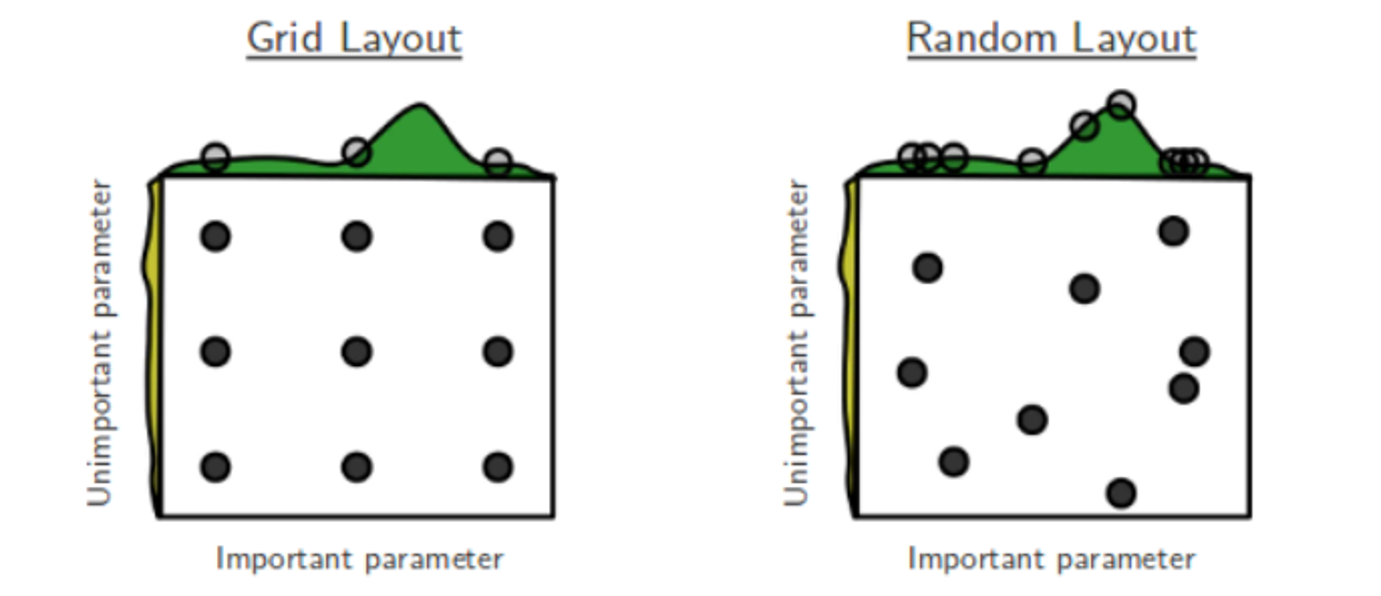

But recent research by Canadians 
>*Bergstra, James, and Yoshua Bengio. “Random Search for Hyper-Parameter Optimization.” Journal of Machine Learning Research, Feb. 2012.* 



Found that Random search, where random combinations of every hyperparameter are tested is actually superior in finding the best hyperparameters (which lead to the most accurate model). Try to see why from the image above. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

Just like before, there is a function to do all of this searching. We still need to specify the possible values (in a dictionary! remember this) which each hyperparameter can take, however the possible selections are random, and we can specify how many to search for (this TAKES TIME). By the way, this search occurs with k-fold-validation!

In [ ]:
forest_reg = RandomForestRegressor()
param_space = { 'n_estimators' : [3,10,30,50,100], 
               'max_depth' : [5,10,50,100], 
               'min_samples_split' : [2,10,50], 
               'min_samples_leaf' : [1, 10, 100], 
               'max_features' : [2,4,6,8] }


forest_cv = RandomizedSearchCV(forest_reg, param_space, n_iter=10, scoring = 'neg_root_mean_squared_error', cv = 5 )
search = forest_cv.fit(inputs_new, ypred)



1.   First we declare what model we want to use
2.   Then we create a dictionary (new data type!!) with the format:
```
{ 'name_of_hyperparameter' : [ values to test as list ] , 'next hyperparameter' : [ values to test ] , ... }
```
(the name of the hyperparameter must be spelled exactly, and can be found using the hover or sklern documentation of the model, for random forest, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
>Generally, in the documentation, the most important hyperparameters are listed first
3. Then we use the `RandomizedSearchCV` function we imported, specifing all the inputs as required by hovering over, `n_iter` tells us *how many* random hyperparam combos to try!!
4. `RandomizedSearchCV` is still a scikit object, (at this point it has NO DATA!!) so we need to ***fit*** it to the data we are using, ***this step takes a while***



In [ ]:
search.best_params_

{'max_depth': 50,
 'max_features': 8,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 10}

After we can use the .best_params_ attribute on the search to get the parameters with the best accuracy. Or look at the results directly in a dataframe using the following: 

In [ ]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.828692,0.008954,0.005653,0.000610,10,10,10,8,50,"{'n_estimators': 10, 'min_samples_split': 10, ...",-80699.597654,-53982.589316,-79102.691173,-59473.618247,-85130.083036,-71677.715885,12486.378931,1
1,0.123143,0.001663,0.003138,0.000200,10,10,10,2,5,"{'n_estimators': 10, 'min_samples_split': 10, ...",-95575.376606,-61412.034904,-114361.178952,-77504.464172,-107037.431283,-91178.097183,19397.404610,10
2,5.016261,0.067928,0.026743,0.003588,50,10,1,8,100,"{'n_estimators': 50, 'min_samples_split': 10, ...",-99382.667470,-52522.165493,-75927.180773,-58480.549099,-84655.514631,-74193.615493,17108.460610,5
3,3.777507,0.017676,0.033752,0.002529,100,2,10,4,10,"{'n_estimators': 100, 'min_samples_split': 2, ...",-80753.909649,-51964.380851,-85705.736999,-57130.027002,-90281.180063,-73167.046913,15584.683792,3
4,0.130685,0.001827,0.002283,0.000169,3,10,100,6,100,"{'n_estimators': 3, 'min_samples_split': 10, '...",-79201.181085,-56610.614551,-88578.488955,-64924.379238,-84131.001247,-74689.133015,12038.313072,6
5,1.735552,0.020900,0.033581,0.004468,50,2,1,2,50,"{'n_estimators': 50, 'min_samples_split': 2, '...",-94433.604588,-51499.701942,-83675.146602,-60291.341597,-95378.127197,-77055.584385,17975.943530,8
6,0.824802,0.013029,0.005382,0.000514,10,50,1,8,50,"{'n_estimators': 10, 'min_samples_split': 50, ...",-108870.992783,-52926.196377,-78724.581515,-60409.961172,-85998.143717,-77385.975113,19767.313818,9
7,0.213240,0.002899,0.002494,0.000080,3,50,10,8,10,"{'n_estimators': 3, 'min_samples_split': 50, '...",-81775.256488,-56069.630339,-84040.325677,-59740.969551,-87248.933759,-73775.023163,13125.258333,4
8,0.551394,0.004428,0.004944,0.000282,10,2,10,6,10,"{'n_estimators': 10, 'min_samples_split': 2, '...",-79746.525732,-52056.179983,-82857.671104,-59103.207980,-86520.472636,-72056.811487,13804.411410,2
9,3.720235,0.012838,0.031310,0.002920,100,50,1,4,10,"{'n_estimators': 100, 'min_samples_split': 50,...",-88277.922457,-52105.447729,-86578.346650,-58170.787853,-91289.422561,-75284.385450,16629.402593,7


If you were curious how RANDOMSEARCH worked? It involves a for loop :) 

And now, we use those best parameters! (The first time we used random forest was with default parameters). We want to use all of the training data we have now (no more validation) so fit once `inputs_new`. 

In [ ]:
forest_reg = RandomForestRegressor(n_estimators = 10, max_depth = 100, max_features=8, min_samples_leaf = 10, min_samples_split = 10 )
forest_reg.fit(inputs_new, ypred)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Looks good, now to finally test how good this model by making predictions on `df_finaltest`, remember? 
![alt text](https://i.imgur.com/qdqE0O2.png)

> ***However, we made new features in the training data, so we need to do the same for `df_finaltest`.***

In [ ]:
df_newfeats = df_finaltest.copy()
df_newfeats['bedrooms_per_room'] = df_newfeats['total_bedrooms'] / df_newfeats['total_rooms']
df_newfeats['population_per_household'] = df_newfeats['population'] / df_newfeats['households']
df_newfeats['long_over_lat'] = df_newfeats['longitude'] / (4*df_newfeats['latitude'])

In [ ]:
testinputs_new = df_newfeats.drop(columns = 'median_house_value')
ytest_true = df_newfeats['median_house_value']

One final prediction:

In [ ]:
finalpred = forest_reg.predict(testinputs_new)

A scatter plot of predicted values and the actual true values. 

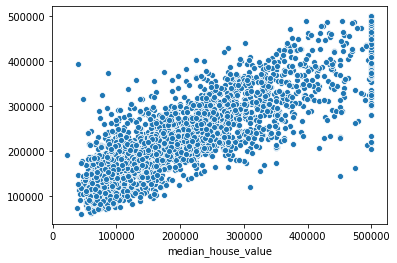

In [ ]:
sns.scatterplot(ytest_true, finalpred)

And we can use this metric to compare the error of the two series!

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(ytest_true, finalpred))

67768.90439693771